# 1. Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor, KerasClassifier
from scipy.stats import reciprocal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import time
import itertools
print(tf.__version__)

2.15.0


In [4]:
# Read the input file
df = pd.read_csv('train.csv')
print(df.shape)

(42000, 785)


# 2. Exploration

In [5]:
# Checking for missing values
df.isna().sum().max()

0

In [6]:
# Checking for duplicates()
df.duplicated().sum()

0

In [7]:
# Show the first 5 rows
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Show the data-summary
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


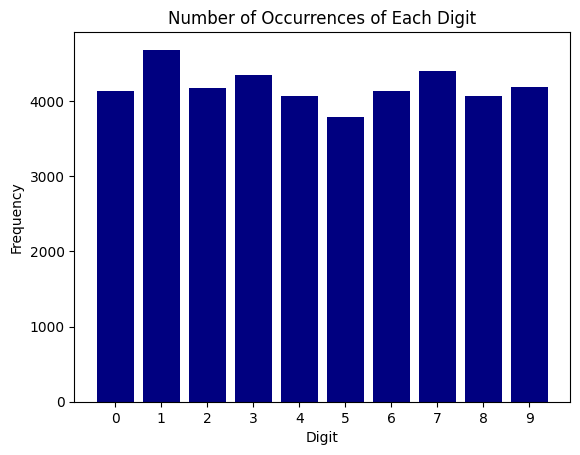

In [9]:
# Count the occurrences of each label and sort by index (digit)
label_counts = df['label'].value_counts().sort_index()

# Ensure all digits are represented in the x-axis, even if their count is zero
all_digits = np.arange(0, 10)

# Get counts for each digit, fill missing ones with zero
counts = label_counts.reindex(all_digits, fill_value=0)

# Create bar plot
plt.bar(counts.index, counts.values, color='navy')

plt.title('Number of Occurrences of Each Digit')
plt.xlabel('Digit')
plt.ylabel('Frequency')

# Set x-ticks to be clearly labeled for each digit
plt.xticks(all_digits)

plt.show()


The distribution of digits is roughly uniform, suggesting a balanced dataset which is ideal for machine learning classification tasks, as it may prevent bias towards more frequent classes.

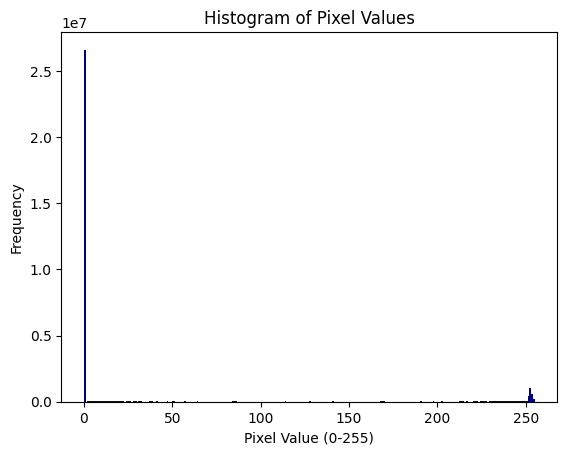

In [10]:
# Plot the histogram for pixel-distribution

# Drop the 'label' column and convert the data to a 1D array
pixel_values = df.drop('label', axis=1).values.flatten()

# Generate the histogram
plt.hist(pixel_values, bins=256, color='navy')

plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Frequency')

plt.show()


The pronounced peak at the left indicates an abundance of black pixels, while the peak at the right suggests a presence of white pixels. The scarcity of mid-range values implies these images have high contrast with predominantly black backgrounds and lighter features i.e. digits are typically white on a black background, contributing to the stark bimodal distribution observed.

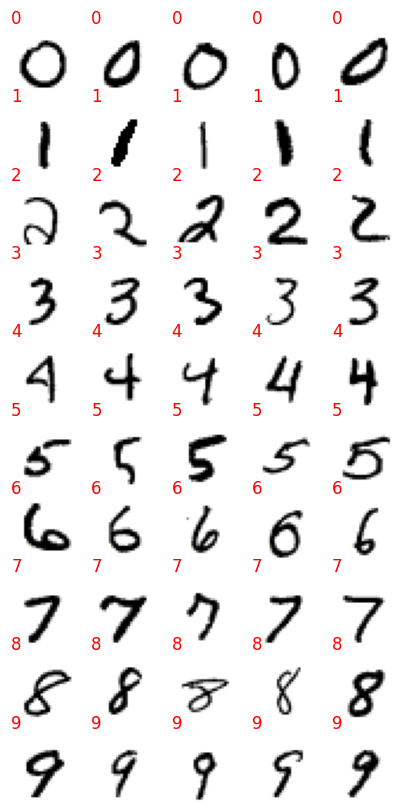

In [11]:
# Display Samples Digits

# Number of samples to display for each digit
num_samples = 5

# Calculate the number of unique digits in df
num_digits = df['label'].nunique()

# Plot the digits
fig, axs = plt.subplots(num_digits, num_samples, figsize=(num_samples, num_digits))
for i in range(num_digits):
    digits = df[df['label'] == i].sample(num_samples)
    for j in range(num_samples):
        img_data = digits.iloc[j, 1:].values.reshape(28, 28)
        axs[i, j].imshow(img_data, cmap=plt.cm.binary)
        # Place a text label inside each subplot
        axs[i, j].text(0, -4, str(i), color='red', fontsize=12)
        axs[i, j].axis('off')

plt.show()


# 3. Pre-modelling

In [12]:
# Define the features and target variable for Modelling
X = df.drop('label', axis=1).values
y = df['label'].values

In [13]:
X.shape

(42000, 784)

In [14]:
# Fit and transform the data
X_scaled = X.astype(float) / 255

In [16]:
# Read the test_file
test_df = pd.read_csv('test.csv')
print(test_df.shape)

(28000, 784)


In [17]:
# Normalize the test values
X_test = test_df.values / 255

# 4. Modelling

## 4a. Dense Neural Network

The code outlines a method for optimizing a neural network's structure via grid search, focusing on hyperparameters like the number of layers and neurons. Using the `build_model` function, it builds models with different configurations, evaluated against a dataset split into training and validation sets. This approach allows for exhaustive exploration of parameter combinations to identify the most effective neural network architecture. The process employs the Keras library for model construction and optimization, leveraging the `GridSearchCV` class from Scikit-Learn for systematic hyperparameter tuning, aiming to maximize accuracy. Results are collected and displayed, highlighting the impact of different configurations on model performance.

In [18]:
# Define a function to build the neural network model
def build_model(n_layers=2, n_neurons=10, learning_rate=3e-3, input_shape=[784] ):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the parameter grid for the grid search
param_grid = {
    'n_layers': [2, 5],
    'n_neurons': [14, 28, 56]
}

# Initialize the KerasClassifier with build_model function
keras_cls = KerasClassifier(build_model, n_layers=2, n_neurons=10, learning_rate=3e-3, input_shape=[784])

# Initialize GridSearchCV with the parameter grid and accuracy scoring
grid_search = GridSearchCV(keras_cls, param_grid, cv=3, scoring='accuracy')  # Using 'accuracy' scoring

# Fit the grid search to the data
results = []
for n_layers in param_grid['n_layers']:
    for n_neurons in param_grid['n_neurons']:
        keras_cls.set_params(n_layers=n_layers, n_neurons=n_neurons)
        start_time = time.time()
        grid_search.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])
        elapsed_time = time.time() - start_time

        # Get the best score and model for the current configuration
        best_score = grid_search.best_score_
        best_model_1 = grid_search.best_estimator_.model_

        # Evaluate on training and validation data
        train_accuracy = grid_search.score(X_train, y_train)
        valid_accuracy = grid_search.score(X_valid, y_valid)

        # Store the results
        results.append({
            'Layers': n_layers,
            'Nodes': n_neurons,
            'Time': round(elapsed_time, 2),
            'Training Accuracy': round(train_accuracy, 3),
            'Validation Accuracy': round(valid_accuracy, 3)
        })

# Print the results in a tabular format
print(f"{'Layers':<7} {'Nodes':<6} {'Time':<5} {'Training Accuracy':<17} {'Validation Accuracy'}")
for res in results:
    print(f"{res['Layers']:<7} {res['Nodes']:<6} {res['Time']:<5} {res['Training Accuracy']:<17} {res['Validation Accuracy']}")


263/263 [==============================] - 0s 1ms/step
Layers  Nodes  Time  Training Accuracy Validation Accuracy
2       14     93.63 0.953             0.943
2       28     90.61 0.956             0.942
2       56     91.84 0.945             0.934
5       14     92.83 0.948             0.937
5       28     91.05 0.953             0.944
5       56     92.11 0.957             0.946


The search tested combinations of 2 and 5 layers with 14, 28, and 56 nodes, assessing their impact on model performance over time, and evaluating training and validation accuracy. Models with 5 layers and 56 nodes achieved the highest validation accuracy (0.946) and training accuracy (0.957), indicating a potential sweet spot in complexity for this particular dataset. Conversely, models with 2 layers and 56 nodes showed lower validation accuracy (0.934), suggesting that simply increasing nodes without adjusting layers might not always yield better results.

In [19]:
# Identify the model with the highest validation accuracy
best_model_1_results = max(results, key=lambda x: x['Validation Accuracy'])

print("\nBest Model:")
print(f"Layers: {best_model_1_results['Layers']}")
print(f"Nodes: {best_model_1_results['Nodes']}")
print(f"Time: {best_model_1_results['Time']}")
print(f"Training Accuracy: {best_model_1_results['Training Accuracy']}")
print(f"Validation Accuracy: {best_model_1_results['Validation Accuracy']}")


Best Model:
Layers: 5
Nodes: 56
Time: 92.11
Training Accuracy: 0.957
Validation Accuracy: 0.946


The best model, identified through grid search, consists of 5 layers with 56 nodes each, taking 92.11 seconds to train. It achieved a high training accuracy of 95.7% and a validation accuracy of 94.6%, indicating excellent performance and generalization ability on unseen data, making it the optimal configuration tested.

In [21]:
# Fit test data to the Best Neural Net Model and write the output file
predictions = best_model_1.predict(X_test).argmax(axis=1)
n_net = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
n_net.to_csv('n_net.csv', index=False)

875/875 [==============================] - 1s 1ms/step


In [22]:
# Assuming X_train and X_valid are your original data with shapes (num_samples, 784)
X_train = X_train.reshape((-1, 28, 28, 1))  # Reshape to (num_samples, 28, 28, 1)
X_valid = X_valid.reshape((-1, 28, 28, 1))  # Reshape to (num_samples, 28, 28, 1)


In [15]:
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 4b. Convolutional Neural Network (CNN)

This code introduces an approach to optimize a Convolutional Neural Network (CNN) model for image classification tasks. It involves defining a function, `build_cnn_model`, which constructs a CNN with customizable parameters such as the number of convolutional layers, number of filters, kernel size, learning rate, and input shape. The model aims to maximize accuracy through iterative training and validation, utilizing Keras for model construction and Adam for optimization. A grid search strategy is employed to systematically explore different configurations of convolutional layers and filters, facilitated by the `GridSearchCV` tool from Scikit-Learn, with the objective of finding the optimal model settings for enhanced performance on a given dataset.

In [23]:
# Define a function to build the CNN model
def build_cnn_model(n_conv_layers=2, n_filters=32, kernel_size=3, learning_rate=1e-3, input_shape=[28, 28, 1]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_conv_layers):
        model.add(keras.layers.Conv2D(n_filters, kernel_size, activation='relu', padding='same'))
        model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the parameter grid for the grid search
param_grid = {
    'n_conv_layers': [2, 3],
    'n_filters': [28, 56]
}

# Initialize the KerasClassifier with build_cnn_model function
cnn_cls = KerasClassifier(build_cnn_model, n_conv_layers=2, n_filters=32, kernel_size=3, learning_rate=1e-3, input_shape=[28, 28, 1])

# Initialize GridSearchCV with the parameter grid and accuracy scoring
grid_search = GridSearchCV(estimator=cnn_cls, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
results = []
for n_conv_layers in param_grid['n_conv_layers']:
    for n_filters in param_grid['n_filters']:
        cnn_cls.set_params(n_conv_layers=n_conv_layers, n_filters=n_filters)
        start_time = time.time()
        grid_search.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])
        elapsed_time = time.time() - start_time

        # Get the best score and model for the current configuration
        best_score = grid_search.best_score_
        best_model_2 = grid_search.best_estimator_.model_

        # Evaluate on training and validation data
        train_accuracy = grid_search.score(X_train, y_train)
        valid_accuracy = grid_search.score(X_valid, y_valid)

        # Store the results
        results.append({
            'Conv Layers': n_conv_layers,
            'Filters': n_filters,
            'Time': round(elapsed_time, 2),
            'Training Accuracy': round(train_accuracy, 3),
            'Validation Accuracy': round(valid_accuracy, 3)
        })

# Print the results in a tabular format
print(f"{'Conv Layers':<12} {'Filters':<7} {'Time':<5} {'Training Accuracy':<17} {'Validation Accuracy'}")
for res in results:
    print(f"{res['Conv Layers']:<12} {res['Filters']:<7} {res['Time']:<5} {res['Training Accuracy']:<17} {res['Validation Accuracy']}")


263/263 [==============================] - 0s 2ms/step
Conv Layers  Filters Time  Training Accuracy Validation Accuracy
2            28      71.71 0.988             0.983
2            56      70.75 0.975             0.975
3            28      69.24 0.981             0.976
3            56      70.22 0.982             0.978


The summary details the outcomes of optimizing a Convolutional Neural Network (CNN) through grid search, varying the number of convolutional layers and filters. The configurations explored include 2 or 3 convolutional layers with 28 or 56 filters. The best model, with 2 convolutional layers and 28 filters, achieved the highest training accuracy of 98.8% and validation accuracy of 98.3%, indicating superior performance and generalizability. Models with more filters or layers did not necessarily perform better, highlighting the importance of finding the right balance between model complexity and efficiency for optimal performance.

In [24]:
# Identify the model with the highest validation accuracy
best_model_2_results = max(results, key=lambda x: x['Validation Accuracy'])

print("\nBest Model:")
print(f"Conv Layers: {best_model_2_results['Conv Layers']}")
print(f"Filters: {best_model_2_results['Filters']}")
print(f"Time: {best_model_2_results['Time']}")
print(f"Training Accuracy: {best_model_2_results['Training Accuracy']}")
print(f"Validation Accuracy: {best_model_2_results['Validation Accuracy']}")


Best Model:
Conv Layers: 2
Filters: 28
Time: 71.71
Training Accuracy: 0.988
Validation Accuracy: 0.983


The optimal CNN model, determined through grid search, features 2 convolutional layers with 28 filters each, trained in 71.71 seconds. It showcases outstanding efficiency and effectiveness, achieving a high training accuracy of 98.8% and a validation accuracy of 98.3%. This configuration excels in balancing complexity with performance, making it highly effective for the task.

In [26]:
# Reshape test data
X_test = X_test.reshape((-1, 28, 28, 1))

# Fit the test data to the best model
predictions = grid_search.best_estimator_.model_.predict(X_test)

# Convert the predictions from one-hot encoded class probabilities to class labels
labels = np.argmax(predictions, axis=-1)

# Now, create the DataFrame using the 1-dimensional labels
cnn = pd.DataFrame({'ImageId': range(1, len(labels)+1), 'Label': labels})

# Save the DataFrame to a CSV file
cnn.to_csv('cnn.csv', index=False)


875/875 [==============================] - 1s 2ms/step


## 4c. Long Short-Term Memory (LSTM)

We are designing and optimizing a Long Short-Term Memory (LSTM) neural network model for sequence data processing. The `build_lstm_model` function is central to this process, enabling the creation of models with varying numbers of LSTM layers and units, tailored to the specific structure of the input data. By leveraging a grid search technique, the code aims to find the optimal combination of LSTM layers and units that maximizes model accuracy. This approach is facilitated by Keras for model construction and optimization, and the search for the best hyperparameters is conducted using Scikit-Learn's `GridSearchCV`, focusing on maximizing accuracy. The process not only involves model training and validation but also a thorough evaluation of the results to identify the configuration that offers the best performance on the given dataset.

In [27]:
# Define a function to build the LSTM model
def build_lstm_model(n_lstm_layers=1, n_units=50, learning_rate=1e-3, input_shape=[28, 28]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_lstm_layers):
        # Return sequences for all but last LSTM layer
        return_sequences = layer < n_lstm_layers - 1
        model.add(keras.layers.LSTM(n_units, return_sequences=return_sequences))
    model.add(keras.layers.Flatten()) # Only necessary if you have more than 1 LSTM layer
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the parameter grid for the grid search
param_grid = {
    'n_lstm_layers': [1, 2],
    'n_units': [50, 100]
}

# Initialize the KerasClassifier with build_lstm_model function
lstm_cls = KerasClassifier(build_lstm_model, n_lstm_layers=1, n_units=50, learning_rate=1e-3, input_shape=[28, 28])

# Initialize GridSearchCV with the parameter grid and accuracy scoring
grid_search = GridSearchCV(estimator=lstm_cls, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
results = []
for n_lstm_layers in param_grid['n_lstm_layers']:
    for n_units in param_grid['n_units']:
        lstm_cls.set_params(n_lstm_layers=n_lstm_layers, n_units=n_units)
        start_time = time.time()
        grid_search.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])
        elapsed_time = time.time() - start_time

        # Get the best score and model for the current configuration
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_.model_

        # Evaluate on training and validation data
        train_accuracy = grid_search.score(X_train, y_train)
        valid_accuracy = grid_search.score(X_valid, y_valid)

        # Store the results
        results.append({
            'LSTM Layers': n_lstm_layers,
            'Units': n_units,
            'Time': round(elapsed_time, 2),
            'Training Accuracy': round(train_accuracy, 3),
            'Validation Accuracy': round(valid_accuracy, 3)
        })

# Print the results in a tabular format
print(f"{'LSTM Layers':<12} {'Units':<6} {'Time':<5} {'Training Accuracy':<17} {'Validation Accuracy'}")
for res in results:
    print(f"{res['LSTM Layers']:<12} {res['Units']:<6} {res['Time']:<5} {res['Training Accuracy']:<17} {res['Validation Accuracy']}")


263/263 [==============================] - 1s 3ms/step
LSTM Layers  Units  Time  Training Accuracy Validation Accuracy
1            50     124.74 0.948             0.942
1            100    123.84 0.942             0.941
2            50     121.13 0.949             0.946
2            100    125.61 0.955             0.949


The summary showcases the results of optimizing a Long Short-Term Memory (LSTM) network through varying the number of layers and units. Models were assessed based on their training and validation accuracies. The configuration with 2 LSTM layers and 100 units emerged as the most effective, achieving the highest training accuracy of 95.5% and validation accuracy of 94.9%. This indicates that increasing both the number of layers and the complexity (units) of the LSTM model can lead to improved performance on the dataset, suggesting a better capability to capture complex patterns and dependencies in the data.

In [28]:
# Identify the model with the highest validation accuracy
best_lstm_results = max(results, key=lambda x: x['Validation Accuracy'])

print("\nBest LSTM Model:")
print(f"LSTM Layers: {best_lstm_results['LSTM Layers']}")
print(f"Units: {best_lstm_results['Units']}")
print(f"Time: {best_lstm_results['Time']}")
print(f"Training Accuracy: {best_lstm_results['Training Accuracy']}")
print(f"Validation Accuracy: {best_lstm_results['Validation Accuracy']}")



Best LSTM Model:
LSTM Layers: 2
Units: 100
Time: 125.61
Training Accuracy: 0.955
Validation Accuracy: 0.949


The optimal LSTM model, identified through systematic testing, comprises 2 layers and 100 units, requiring 125.61 seconds to train. It stands out with a high training accuracy of 95.5% and a validation accuracy of 94.9%, demonstrating its superior ability to learn and generalize from the sequence data efficiently and effectively.

In [30]:
# Fit the test data to the best LSTM model
predictions = grid_search.best_estimator_.model_.predict(X_test)  # Notice the change from model_ to model

# Convert the predictions from probabilities to class labels
labels = np.argmax(predictions, axis=1)

# Create a DataFrame using the 1-dimensional labels
lstm_results = pd.DataFrame({'ImageId': range(1, len(labels) + 1), 'Label': labels})

# Save the DataFrame to a CSV file
lstm_results.to_csv('lstm_results.csv', index=False)

875/875 [==============================] - 2s 3ms/step


# 5. Conclusion

Analyzing the outcomes from experiments with traditional densely connected Neural Networks alongside those of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks provides a comprehensive view of model optimization across different data types and architectural paradigms. The densely connected network optimization highlighted the effectiveness of deeper models with more neurons, particularly showing that a configuration with 5 layers and 56 neurons outperformed others in terms of validation accuracy. This finding aligns with the broader theme observed across the experiments: the importance of tailoring the network architecture to the task at hand for optimal performance.

The CNNs proved most adept at image processing tasks, optimizing at a relatively simpler architecture with 2 layers and 28 filters, emphasizing the value of spatial feature extraction in image data. In contrast, the LSTMs, with their ability to process sequential data, reached peak performance with 2 layers and 100 units, showcasing their strength in capturing temporal dependencies.

Across all models, the grid search strategy was essential in navigating the complex landscape of hyperparameters to identify configurations that maximize accuracy. This exploration underscores the critical role of architectural design in achieving high performance, demonstrating that while there is no universal solution, certain patterns—such as the depth of the network and the number of processing units—consistently influence outcomes. These insights reinforce the principle that effective model optimization is contingent on understanding the unique characteristics of the dataset and task, guiding the selection of the most suitable neural network architecture.